In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
df = pd.read_csv('cleaned_data.csv')

In [3]:
df.head()

,Mkt-RF,SP500,VIXCLS,DEXJPUS,NIKKEI225,T10Y3M,ads_index,open,high,low,close
0,0.62,3039.42,13.11,109.02,22867.27,0.20,-0.670693,59.853616,60.296314,59.684279,60.247932
1,-0.13,3036.89,13.20,108.83,22974.13,0.21,-0.633029,60.228575,60.417265,58.680346,58.854519
2,0.27,3046.77,12.33,108.88,22843.12,0.16,-0.592919,59.210137,59.340771,58.351356,58.847271
3,-0.38,3037.56,13.22,108.09,22927.04,0.15,-0.550348,59.810074,60.276961,57.395800,60.177776
4,1.08,3066.91,12.30,108.16,22850.77,0.21,-0.505299,60.366473,61.912284,60.274549,61.885677


In [4]:
# Data cleaning: Replace specified characters with NaN and drop remaining NaN rows

df1=df.copy()
df1.dropna(inplace=True)


Training Ridge model...
Best Parameters: {'model__alpha': 0.1}


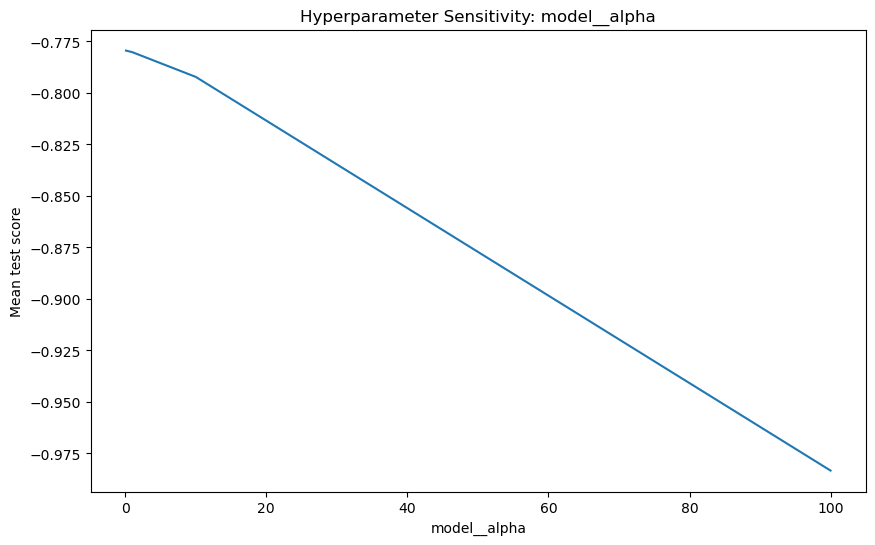

Cross-Validation MSE: 0.7794286246767433
Cross-Validation MAE: 0.6683015085988244


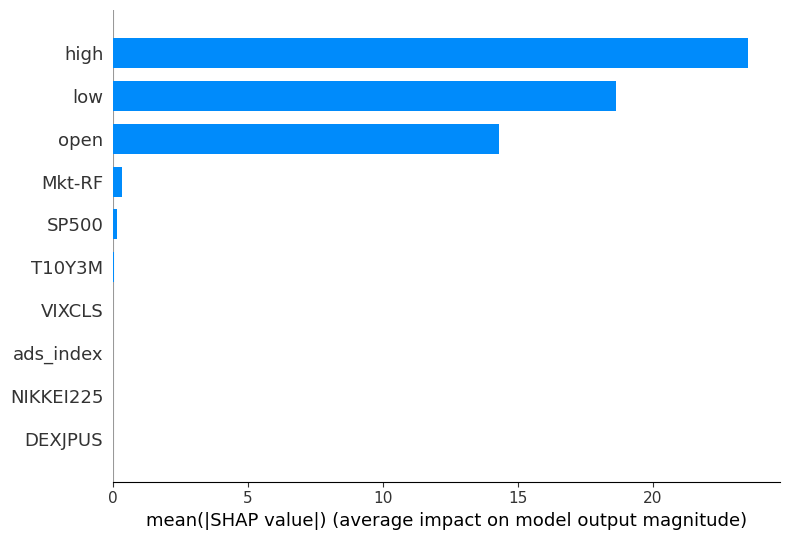

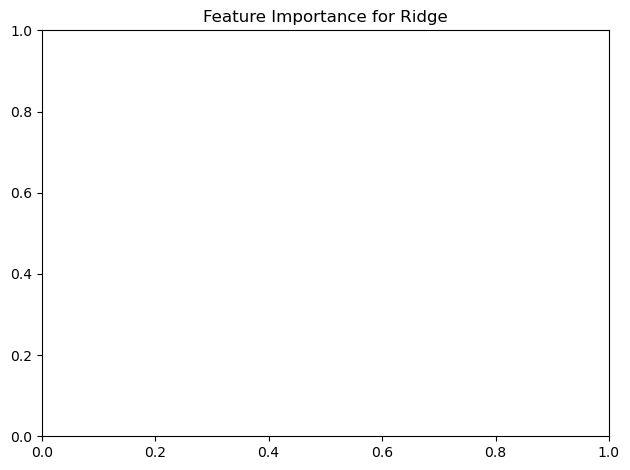


Ridge Coefficients:


TypeError: 'Ridge' object is not subscriptable

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import shap


# Define the data preparation function
def prepare_data(data, features, target, test_size=0.2):
    X = df1.drop(['close'], axis=1)
    y = df1['close']
    
    split_index = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    return X_train, X_test, y_train, y_test

# Define model training and evaluation function with hyperparameter tuning and imputation
def train_evaluate_model(model, X_train, y_train, tscv, param_grid=None):
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Handle NaNs in the dataset
        ('model', model)
    ])
    
    if param_grid:
        search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error')
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
        print(f"Best Parameters: {best_params}")
        
        # Hyperparameter sensitivity analysis
        results = pd.DataFrame(search.cv_results_)
        for param in param_grid:
            plt.figure(figsize=(10, 6))
            plt.plot(results[f'param_{param}'], results['mean_test_score'])
            plt.xlabel(param)
            plt.ylabel('Mean test score')
            plt.title(f'Hyperparameter Sensitivity: {param}')
            plt.show()
            
    else:
        pipeline.fit(X_train, y_train)
        best_model = pipeline
    
    # Cross-validation for evaluation metrics
    mse_scores, mae_scores = [], []
    for train_idx, val_idx in tscv.split(X_train):
        X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        best_model.fit(X_cv_train, y_cv_train)
        y_pred = best_model.predict(X_cv_val)
        
        mse_scores.append(mean_squared_error(y_cv_val, y_pred))
        mae_scores.append(mean_absolute_error(y_cv_val, y_pred))
    
    results = {
        'mean_mse': np.mean(mse_scores),
        'mean_mae': np.mean(mae_scores)
    }
    print("Cross-Validation MSE:", results['mean_mse'])
    print("Cross-Validation MAE:", results['mean_mae'])
    
    # Feature importance using SHAP
    explainer = shap.LinearExplainer(best_model['model'], X_train)
    shap_values = explainer.shap_values(X_train)
    
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    plt.title(f"Feature Importance for {type(model).__name__}")
    plt.tight_layout()
    plt.show()
    
    return best_model, results

# Main function for the full pipeline
def time_series_regression_pipeline(data, test_size=0.2):
    features = [col for col in data.columns if col not in ['close']]
    target = 'close'
    
    X_train, X_test, y_train, y_test = prepare_data(data, features, target, test_size)
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    models = {
        'Ridge': (Ridge(), {'model__alpha': [0.1, 1.0, 10.0, 100.0]}),
        'Lasso': (Lasso(), {'model__alpha': [0.1, 1.0, 10.0, 100.0]}),
        'ElasticNet': (ElasticNet(), {'model__alpha': [0.1, 1.0, 10.0, 100.0], 'model__l1_ratio': [0.1, 0.5, 0.9]})
    }
    
    final_models = {}
    for model_name, (model, param_grid) in models.items():
        print(f"Training {model_name} model...")
        best_model, results = train_evaluate_model(model, X_train, y_train, tscv, param_grid)
        final_models[model_name] = best_model
        

        # Perform SHAP analysis on test set
        explainer = shap.LinearExplainer(best_model['model'], X_test)
        shap_values = explainer.shap_values(X_test)
        
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test, plot_type="bar")
        plt.title(f"Feature Importance for {model_name} on Test Set")
        plt.tight_layout()
        plt.show()
        
    
    # Evaluate final models on test set
    for model_name, model in final_models.items():
        y_pred_test = model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        print(f"{model_name} Test MSE: {test_mse}, Test MAE: {test_mae}")
    
    return final_models

# Execute the pipeline
final_models = time_series_regression_pipeline(df1)
